In [1]:
import torch
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ploss_path = "/home/han/test_predictions_ploss.npy"
spec_path = "/home/han/test_predictions_spec.npy"
pnp_path = "/home/han/test_predictions_pnp.npy"

##LOAD PREDICTED AND GROUND TRUTH PARAMETERS FROM EACH MODEL, RESHAPE
gt_ploss,preds_ploss = np.load(ploss_path)
gt_spec,preds_spec = np.load(spec_path)
gt_pnp,preds_pnp = np.load(pnp_path)  # what are their corresponding M matrices?

nb, bs, outdim = gt_ploss.shape

gt_ploss = gt_ploss.reshape(nb*bs, outdim)
preds_ploss = preds_ploss.reshape(nb*bs, outdim)
gt_spec = gt_spec.reshape(nb*bs, outdim)
preds_spec = preds_spec.reshape(nb*bs, outdim)
gt_pnp = gt_pnp.reshape(nb*bs, outdim)
preds_pnp = preds_pnp.reshape(nb*bs, outdim)

In [3]:
import icassp23
#OBTAIN ORIGINAL GROUND TRUTH (BEFORE MIN MAX SCALING)
_, scaler = icassp23.scale_theta() #index are ids
test_df = icassp23.load_fold("test") # not min max scaled
thetas = np.stack([
    test_df[column].values for column in icassp23.THETA_COLUMNS
], axis=1)

theta_norm = scaler.transform(thetas)

In [4]:
#VERIFY IF TEST RESULTS FROM EACH MODEL ARE OF THE SAME SEQUENCE
assert np.any(gt_ploss == gt_pnp) and np.any(gt_ploss == gt_spec)


In [5]:
## OBTAIN THEIR CORRESPONDING M MATRICES' DIAGONAL TERMS
M_dir = "/home/han/localdata/data/ftm_jtfs/M/icassp23_test_M.h5"
diags = []
for o_idx in np.arange(gt_ploss.shape[0]):
    idx = np.argmin(np.linalg.norm(gt_ploss[o_idx,:]-theta_norm,axis=1)) #find where in dataframe
    id = test_df.values[idx,0] #recover id
    with h5py.File(M_dir,"r") as f:
        M = torch.tensor(np.array(f['M'][str(id)]))
        diags.append(np.diagonal(M))
diags = np.stack(diags)


In [6]:
#COMPUTE THE PARAMETER L2 ERRORS
err_ploss = np.log10((gt_ploss - preds_ploss)**2)
err_spec = np.log10((gt_spec - preds_spec)**2)
err_pnp = np.log10((gt_pnp - preds_pnp)**2)

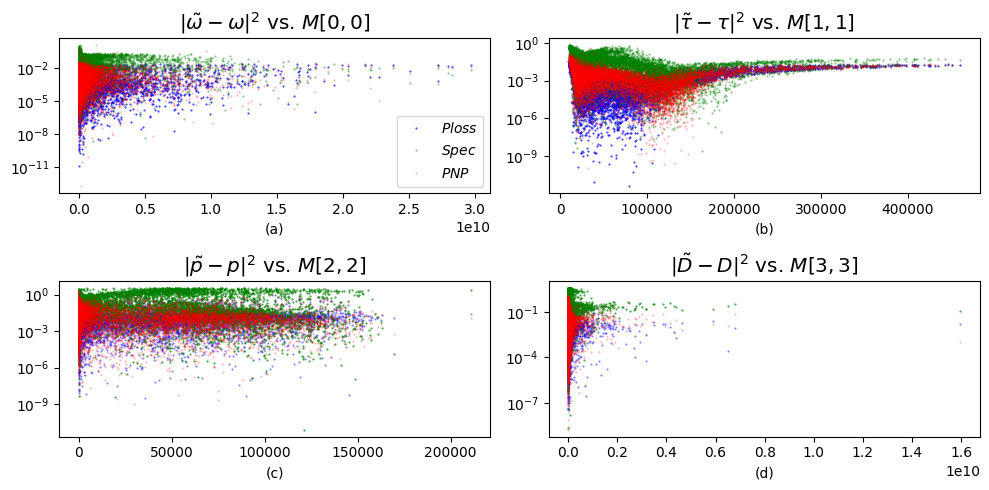

In [7]:
#make plots
import matplotlib as mlp
label_size = 10
mlp.rcParams['xtick.labelsize'] = label_size 
mlp.rcParams['ytick.labelsize'] = label_size 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(10,5))
i = 0
ax1.semilogy(diags[:,i],10**err_ploss[:,i],'b.',markersize=1,label=r"$Ploss$",alpha=0.8)
ax1.semilogy(diags[:,i],10**err_spec[:,i],'g.',markersize=1,label=r"$Spec$",alpha=0.5)
ax1.semilogy(diags[:,i],10**err_pnp[:,i],'r.',markersize=1,label=r"$PNP$",alpha=0.3)
ax1.set_title(r'$|\tilde{\omega}-\omega|^2$ vs. $M[0,0]$',fontsize="x-large")
ax1.set_xlabel(r"(a)")
ax1.legend()
i += 1
ax2.semilogy(diags[:,i],10**err_ploss[:,i],'b.',markersize=1,label="ploss",alpha=0.8)
ax2.semilogy(diags[:,i],10**err_spec[:,i],'g.',markersize=1,label="spec",alpha=0.5)
ax2.semilogy(diags[:,i],10**err_pnp[:,i],'r.',markersize=1,label="pnp",alpha=0.3)
ax2.set_title(r"$|\tilde{\tau}-\tau|^2$ vs. $M[1,1]$",fontsize="x-large")
ax2.set_xlabel(r"(b)")
i += 1
ax3.semilogy(diags[:,i],10**err_ploss[:,i],'b.',markersize=1,label="ploss",alpha=0.5)
ax3.semilogy(diags[:,i],10**err_spec[:,i],'g.',markersize=1,label="spec",alpha=0.8)
ax3.semilogy(diags[:,i],10**err_pnp[:,i],'r.',markersize=1,label="pnp",alpha=0.3)
ax3.set_title(r"$|\tilde{p}-p|^2$ vs. $M[2,2]$",fontsize="x-large")
ax3.set_xlabel(r"(c)")
i += 1

ax4.semilogy(diags[:,i],10**err_ploss[:,i],'b.',markersize=1,label="ploss",alpha=0.5)
ax4.semilogy(diags[:,i],10**err_spec[:,i],'g.',markersize=1,label="spec",alpha=0.8)
ax4.semilogy(diags[:,i],10**err_pnp[:,i],'r.',markersize=1,label="pnp",alpha=0.3)
ax4.set_title(r"$|\tilde{D}-D|^2$ vs. $M[3,3]$",fontsize="x-large")
ax4.set_xlabel(r"(d)")
i += 1
#ax5.plot(diags[:,i],err_ploss[:,i],'b.',markersize=1)
#ax5.plot(diags[:,i],err_spec[:,i],'g.',markersize=1)
#ax5.plot(diags[:,i],err_pnp[:,i],'r.',markersize=1)
plt.tight_layout()


Text(0, 0.5, 'cumlative magnitude of M[0,0]')

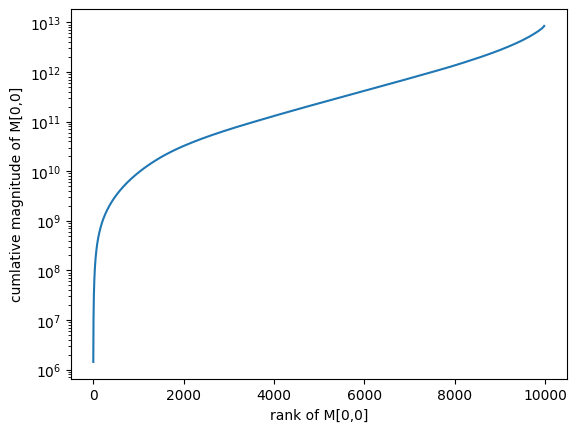

In [8]:
##ALTERNATIVELY, RANK THE M[i,i], PLOT cdf
param_idx = 0
idx = np.argsort(diags[:,param_idx])
sorted_diags = np.sort(diags[:,param_idx])
cdf = np.cumsum(sorted_diags)
plt.semilogy(np.arange(diags.shape[0]), cdf)
plt.xlabel("rank of M[0,0]")
plt.ylabel("cumlative magnitude of M[0,0]")



In [26]:
r"$\tau$"[1:-1]

'\\tau'

In [29]:
def plot_hist(param_idx):
        if param_idx == 0:
                param_str = r"$\omega$"
                t_p = r"$\tilde{\omega}$"
        elif param_idx ==1:
                param_str = r"$\tau$"
                t_p = r"$\tilde{\tau}$"
        elif param_idx ==2:
                param_str = r"$p$"
                t_p = r"$\tilde{p}$"
        elif param_idx == 3:
                param_str = r"$D$"
                t_p = r"$\tilde{D}$"

        idx = np.argsort(diags[:,param_idx])
        sorted_diags = np.sort(diags[:,param_idx])
        #TAKING FIRST 20% AND LATER 20% OF THE POPULATION, MAKE HISTOGRAM OF THEIR ERROR
        small_diag_idx = idx[:len(idx)//5]
        big_diag_idx = idx[-len(idx)//5:]
        small_diag_err_ploss = err_ploss[small_diag_idx,param_idx]
        big_diag_err_ploss = err_ploss[big_diag_idx,param_idx]

        small_diag_err_pnp = err_pnp[small_diag_idx,param_idx]
        big_diag_err_pnp= err_pnp[big_diag_idx,param_idx]

        small_diag_err_spec = err_spec[small_diag_idx,param_idx]
        big_diag_err_spec= err_spec[big_diag_idx,param_idx]
        n_bins = 200
        islog = False
        histtype = "step"
        stacked = False
        density = False
        range = (-8,1)

        fig,axes = plt.subplots(2,1)

        axes[0].hist(small_diag_err_ploss, bins=n_bins,histtype=histtype,label="ploss",log=islog, stacked=stacked,
        density=density,range=range)
        axes[0].hist(small_diag_err_pnp, bins=n_bins, histtype=histtype,label="pnp",log=islog,stacked=stacked,
        density=density,range=range)

        axes[0].set_title(r"small $M[$"+str(param_idx)+r"$,$"+str(param_idx)+r"$]$" )
        axes[1].hist(big_diag_err_ploss, bins=n_bins, histtype=histtype,label="ploss",log=islog,
        density=density,range=range)
        axes[1].hist(big_diag_err_pnp, bins=n_bins,histtype=histtype,label="pnp",log=islog,
        density=density,range=range)
        axes[1].set_title(r"big $M[$"+str(param_idx)+r"$,$"+str(param_idx)+r"$]$" )

        plt.xlabel(r"$\Vert $"+ param_str + r"$-$" + t_p + r"$\Vert^2$")
        plt.legend(["ploss", "pnp","spec"])

        plt.tight_layout()
    

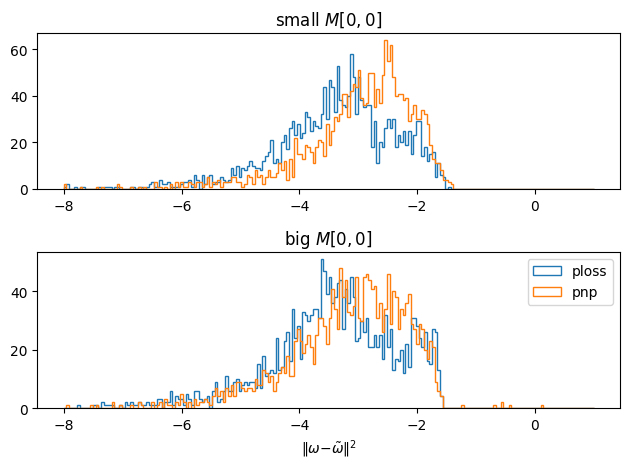

In [30]:
plot_hist(0)

-1.166750004606682 -8.695849839469696 -0.8374209677652346 -7.077240247879265
<class 'numpy.ndarray'>


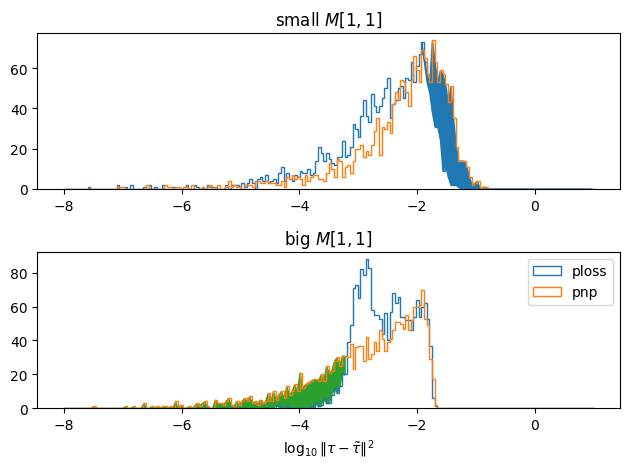

In [76]:
param_idx = 1
idx = np.argsort(diags[:,param_idx])
sorted_diags = np.sort(diags[:,param_idx])
#TAKING FIRST 20% AND LATER 20% OF THE POPULATION, MAKE HISTOGRAM OF THEIR ERROR
#param_idx = 1
small_diag_idx = idx[:len(idx)//5]
big_diag_idx = idx[-len(idx)//5:]
small_diag_err_ploss = err_ploss[small_diag_idx,param_idx]
big_diag_err_ploss = err_ploss[big_diag_idx,param_idx]

small_diag_err_pnp = err_pnp[small_diag_idx,param_idx]
big_diag_err_pnp= err_pnp[big_diag_idx,param_idx]

small_diag_err_spec = err_spec[small_diag_idx,param_idx]
big_diag_err_spec= err_spec[big_diag_idx,param_idx]
n_bins = 200
islog = False
histtype = "step"
stacked = False
density = False
range = (-8,1)
print(np.max(small_diag_err_ploss), np.min(small_diag_err_ploss),
        np.max(small_diag_err_pnp), np.min(small_diag_err_pnp))
print(type(small_diag_err_ploss))

fig,axes = plt.subplots(2,1)

n_up,n_edge,_ =  axes[0].hist(small_diag_err_ploss, bins=n_bins,histtype=histtype,label="ploss",log=islog, stacked=stacked,
            density=density,range=range)
n_up2,n_edge2,_ = axes[0].hist(small_diag_err_pnp, bins=n_bins, histtype=histtype,label="pnp",log=islog,stacked=stacked,
             density=density,range=range)

#identify intersection point, find index of the large
intersection = np.max(np.where(n_up2 < n_up))
fill_x = n_edge[intersection:-1]#(n_edge[1:] + n_edge[:-1]) / 2
axes[0].fill_between(fill_x,n_up[intersection:],n_up2[intersection:], color="C0")
#axes[0].hist(small_diag_err_spec, bins=n_bins, histtype=histtype,label="spec",log=islog, 
#    stacked=stacked, density=density,range=range)
#axes[0].set_xlim([0,0.01])
#axes[0].set_ylim([0,400])
axes[0].set_title(r"small $M[1,1]$" )
n_up3, n_edge3, _ = axes[1].hist(big_diag_err_ploss, bins=n_bins, histtype=histtype,label="ploss",log=islog,
        density=density,range=range)
n_up4, n_edge4, _ = axes[1].hist(big_diag_err_pnp, bins=n_bins,histtype=histtype,label="pnp",log=islog,
        density=density,range=range)

#intersection point 
intersection = np.min(np.where(n_up3 > n_up4))
fill_x = n_edge[:intersection] #(n_edge3[1:] + n_edge[:-1]) / 2
axes[1].fill_between(fill_x, n_up3[:intersection], n_up4[:intersection], color="C2")
#axes[1].hist(big_diag_err_spec, bins=n_bins, histtype=histtype,label="spec",log=islog,
#        density=density,range=range)
#axes[1].set_xlim([0,0.01])
#axes[1].set_ylim([0,400])
axes[1].set_title(r"big $M[1,1]$")
plt.xlabel(r"$\log_{10} \Vert \tau-\tilde{\tau} \Vert^2$")
plt.legend(["ploss", "pnp"])

plt.tight_layout()

In [58]:
small_diag_err_pnp.shape

(1996,)

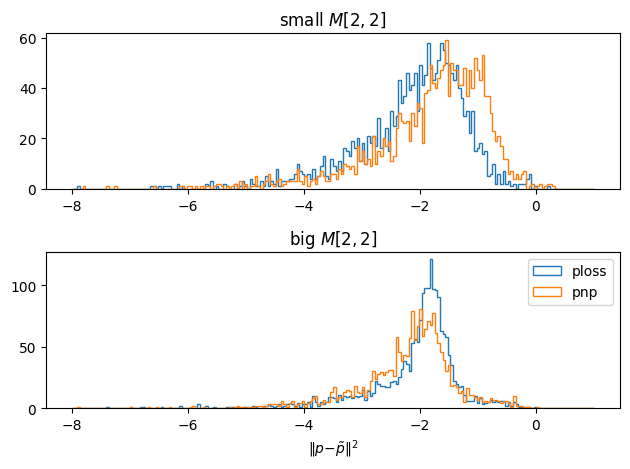

In [32]:
plot_hist(2)

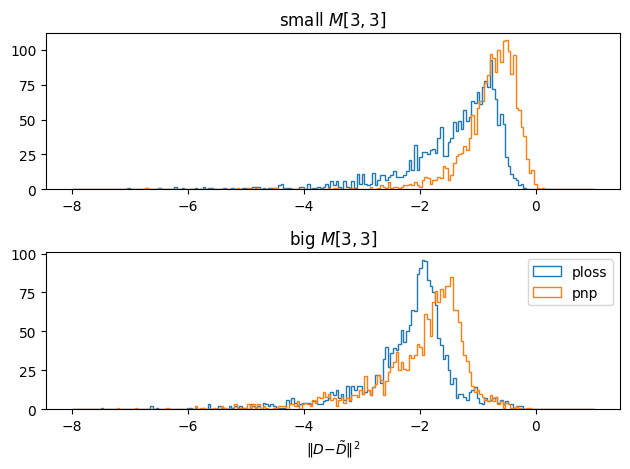

In [33]:
plot_hist(3)